#Set-Up

In [16]:
#Copy-and-paste the code below to use as "set-up" when your optimization model uses Pyomo and Coin-OR solvers.
#for reference, see https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/01.02-Running-Pyomo-on-Google-Colab.html#installing-pyomo-and-solvers

%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

from pyomo.environ import *

#Optimizing Housing Recommendations for Graduate Students at WSB

*Input:*

In [17]:
property_names = [
    "The James", "The Hub", "Lucky Apartments", "The Highlander",
    "Equinox Apartments", "The Regent", "Brownstone on Old Univ",
    "Lark at Randall", "420 West Gorham St", "Campus Square"
]
N = len(property_names)  # Number of housing options
c = [650, 700, 680, 620, 750, 700, 600, 720, 630, 675]  # Monthly rent
d = [0.4, 0.3, 0.5, 0.6, 0.8, 0.7, 0.3, 0.9, 0.5, 0.4]  # Distance in miles
b = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  # Near bus stop (1 if yes, 0 if no)
s = [1, 1, 1, 1, 1, 0, 1, 0, 1, 1]  # Near supermarket (1 if yes, 0 if no)
t = [2, 2, 1, 1, 2, 2, 1, 2, 1, 2]  # Housing type (1 = 2B1B, 2 = 2B2B)

*Constraints:*

In [18]:
R = 700  # Rent budget
D = 1.0  # Maximum walking distance (in miles)

*Decision variables:*

In [19]:
# Create a concrete model
model = ConcreteModel()

model.x = Var(range(N), domain=Binary)  # Whether housing option i is chosen

*Objective: Minimize total rent*

In [20]:

model.obj = Objective(expr=sum(c[i] * model.x[i] for i in range(N)), sense=minimize)

*Constraints:*

In [21]:
# Constraints
# Only one housing option can be chosen
model.single_choice = Constraint(expr=sum(model.x[i] for i in range(N)) == 1)

# Rent constraint
model.rent_constraint = Constraint(expr=sum(c[i] * model.x[i] for i in range(N)) <= R)

# Distance or bus stop proximity
model.proximity_constraint = ConstraintList()
for i in range(N):
    if d[i] <= D or b[i] == 1:  # Ensure either within distance or near bus stop
        model.proximity_constraint.add(model.x[i] <= 1)

# Supermarket proximity
model.supermarket_constraint = ConstraintList()
for i in range(N):
    if s[i] == 1:  # Ensure near a supermarket
        model.supermarket_constraint.add(model.x[i] <= 1)

*Solver:*

In [22]:

solver = SolverFactory('cbc')  # Ensure CBC is installed
result = solver.solve(model)


*Output:*

In [23]:

if result.solver.termination_condition == TerminationCondition.optimal:
    print("Optimal solution found!")
    for i in range(N):
        if model.x[i]() > 0.5:  # Check if x[i] is selected
            print(f"  Name: {property_names[i]}")
            print(f"  Rent: ${c[i]}")
            print(f"  Distance from Business School: {d[i]} miles")
            print(f"  Near Bus Stop: {'Yes' if b[i] == 1 else 'No'}")
            print(f"  Near Supermarket: {'Yes' if s[i] == 1 else 'No'}")
            print(f"  Type: {'2B1B' if t[i] == 1 else '2B2B'}")
else:
    print("No optimal solution found.")


Optimal solution found!
  Name: Brownstone on Old Univ
  Rent: $600
  Distance from Business School: 0.3 miles
  Near Bus Stop: Yes
  Near Supermarket: Yes
  Type: 2B1B


*Visualization:*

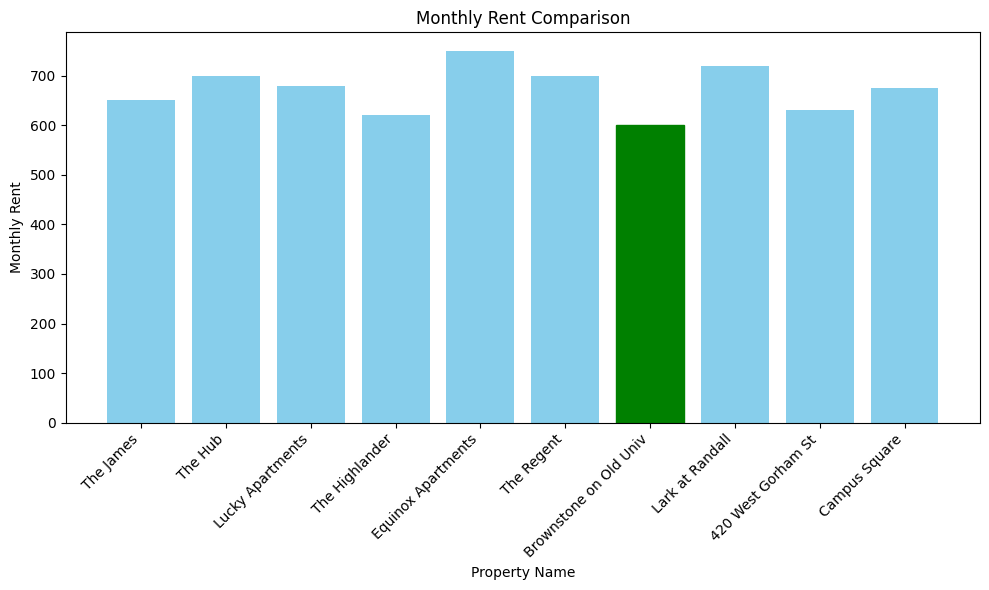

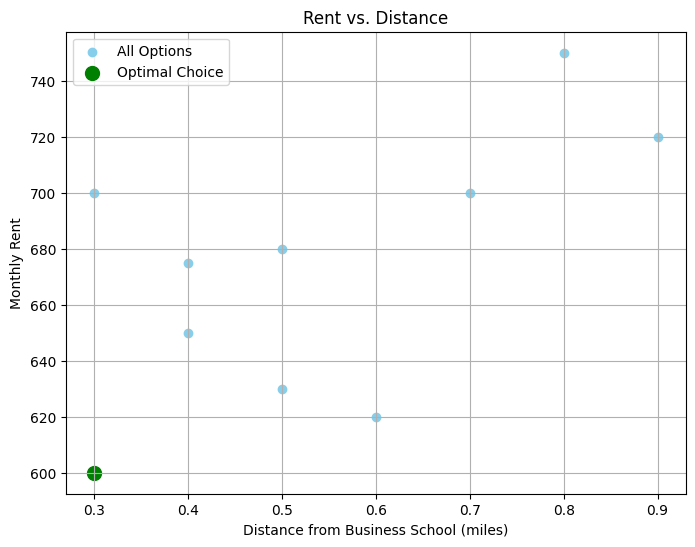

In [28]:
import matplotlib.pyplot as plt

if result.solver.termination_condition == TerminationCondition.optimal:
    optimal_solution = []
    for i in range(N):
      if model.x[i]() > 0.5:
        optimal_solution.append(i)


    # Prepare data for visualization
    property_names_vis = [property_names[i] for i in range(N)]
    rent_vis = [c[i] for i in range(N)]
    distance_vis = [d[i] for i in range(N)]
    bus_vis = ["Yes" if b[i] == 1 else "No" for i in range(N)]
    supermarket_vis = ["Yes" if s[i] == 1 else "No" for i in range(N)]
    type_vis = ["2B1B" if t[i] == 1 else "2B2B" for i in range(N)]


    # Create a bar plot of rent for all options, highlighting the optimal choice
    plt.figure(figsize=(10, 6))
    bars = plt.bar(property_names_vis, rent_vis, color='skyblue')
    bars[optimal_solution[0]].set_color('green') #Highlight optimal solution
    plt.xlabel("Property Name")
    plt.ylabel("Monthly Rent")
    plt.title("Monthly Rent Comparison")
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
    plt.tight_layout()
    plt.show()

    # Create a scatter plot of rent vs. distance, highlighting the optimal choice
    plt.figure(figsize=(8, 6))
    plt.scatter(distance_vis, rent_vis, color='skyblue', label='All Options')
    plt.scatter(distance_vis[optimal_solution[0]], rent_vis[optimal_solution[0]], color='green', s=100, label='Optimal Choice')
    plt.xlabel("Distance from Business School (miles)")
    plt.ylabel("Monthly Rent")
    plt.title("Rent vs. Distance")
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("No optimal solution found. Cannot visualize.")